In [234]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

df = pd.read_csv('../Netflix Analysis/Data/CONTENT_INTERACTION/ViewingActivity.csv')

In [170]:
# Get some prelimnary data
df.shape
df.head

<bound method NDFrame.head of       Profile Name           Start Time  Duration  \
0           Johnny  2023-08-30 04:45:43  00:00:13   
1           Johnny  2023-08-30 04:44:40  00:00:04   
2           Johnny  2023-08-30 04:44:22  00:00:14   
3           Johnny  2023-08-28 02:35:48  00:23:17   
4           Johnny  2023-08-25 06:31:22  00:01:45   
...            ...                  ...       ...   
46098         Meno  2014-10-15 09:08:42  00:39:21   
46099         Meno  2014-10-15 08:26:09  00:42:28   
46100         Meno  2014-10-15 05:42:27  02:42:05   
46101         Meno  2014-10-14 16:18:20  00:00:03   
46102         Meno  2014-10-14 04:59:46  05:21:03   

                            Attributes  \
0      Autoplayed: user action: None;    
1      Autoplayed: user action: None;    
2      Autoplayed: user action: None;    
3                                  NaN   
4                                  NaN   
...                                ...   
46098                              NaN 

In [171]:
# Retrieve all profile names on the account
df["Profile Name"].unique()
# Changing names to make more sense for the reader
df['Profile Name'] = df['Profile Name'].replace(['Lauren','Meno','Mama bear','Johnny'],['Girlfriend','Brother','Mom','Myself'])
df["Profile Name"].unique()

array(['Myself', 'Kids', 'Girlfriend', 'Mom', 'Brother'], dtype=object)

In [172]:
# Check out the data types
df.dtypes

Profile Name               object
Start Time                 object
Duration                   object
Attributes                 object
Title                      object
Supplemental Video Type    object
Device Type                object
Bookmark                   object
Latest Bookmark            object
Country                    object
dtype: object

<p> Looks like the dtypes are all objects. To plot and perform analyis on these columns, we'll need to convert some of them. Let's begin by transforming dtypes of Start Time and Duration </p>

In [173]:
# Convert dtypes
df['Start Time'] = pd.to_datetime(df['Start Time'], utc=True)
df['Duration'] = pd.to_timedelta(df['Duration'])
# Verify the dtypes we're changed
df.dtypes
# Get a random sample of 10 rows
df.sample(n=10)

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
10586,Myself,2017-02-06 03:39:07+00:00,0 days 00:21:31,NaN,How I Met Your Mother: Season 9: Unpause (Epis...,NaN,FireTV STB 2015,00:21:33,00:21:33,US (United States)
28884,Myself,2010-08-15 03:07:14+00:00,0 days 00:23:01,NaN,Hey Arnold!: Season 1: Operation Ruthless / Th...,NaN,NaN,00:23:00,00:23:00,US (United States)
11168,Myself,2016-12-08 17:49:32+00:00,0 days 00:20:13,NaN,Malcolm in the Middle: Season 2: Grandparents ...,NaN,Vizio MG143 Wistron MT5580 NF Smart TV,00:22:05,Not latest view,US (United States)
5011,Myself,2019-10-30 07:45:56+00:00,0 days 00:21:48,Autoplayed: user action: None;,The Office (U.S.): Season 4: Did I Stutter (Ep...,NaN,Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV,00:21:48,00:21:48,US (United States)
8971,Myself,2017-05-28 00:17:56+00:00,0 days 00:03:47,NaN,It's Always Sunny in Philadelphia: Season 6: W...,NaN,Vizio MG143 Wistron MT5580 NF Smart TV,00:03:51,Not latest view,US (United States)
9753,Myself,2017-04-06 01:16:03+00:00,0 days 00:22:23,NaN,Malcolm in the Middle: Season 4: Baby: Part 1 ...,NaN,Vizio MG143 Wistron MT5580 NF Smart TV,00:22:23,Not latest view,US (United States)
2647,Myself,2021-08-14 08:29:14+00:00,0 days 00:40:37,NaN,The Devil Next Door: Limited Series: Facing th...,NaN,Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV,00:41:57,Not latest view,US (United States)
22047,Myself,2013-05-16 11:32:47+00:00,0 days 00:21:13,NaN,Beast Wars: Transformers: Season 1: Beast Wars...,NaN,Wii Bowser,00:21:13,00:21:13,US (United States)
35160,Brother,2022-07-20 04:39:59+00:00,0 days 00:00:04,Autoplayed: user action: None;,Trailer: Girl in the Picture,TRAILER,Amazon Fire TV Stick 2020 Lite Streaming Stick,00:00:04,00:00:04,US (United States)
19283,Myself,2014-02-18 01:30:54+00:00,0 days 00:21:03,NaN,Futurama: Season 7: Holiday Spectacular (Episo...,NaN,PC,00:20:49,Not latest view,US (United States)


In [174]:
# See how many total interactions each profile has. This can be counted as each time the app has been opened per profile
df['Profile Name'].value_counts()

Myself        28887
Brother       14407
Mom            1910
Kids            514
Girlfriend      385
Name: Profile Name, dtype: int64

<p> I've clearly taken the lead with 28,887 interactions. Next place is 14,407 interactions, about double! Let's plot and visualize this drastic difference across all profiles </p>

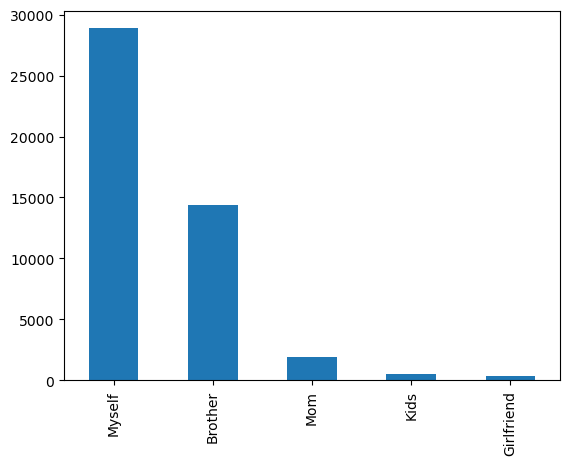

In [175]:
# Plot the interactions per account
df['Profile Name'].value_counts().plot(kind='bar')

plt.show()

In [176]:
# Get a sum of viewing time per each profile
display(df.loc[df['Profile Name']=='Myself','Duration'].sum())
display(df.loc[df['Profile Name']=='Brother','Duration'].sum())
display(df.loc[df['Profile Name']=='Mom','Duration'].sum())
display(df.loc[df['Profile Name']=='Kids','Duration'].sum())
display(df.loc[df['Profile Name']=='Girlfriend','Duration'].sum())

Timedelta('499 days 03:43:42')

Timedelta('255 days 09:01:49')

Timedelta('32 days 13:47:03')

Timedelta('11 days 21:31:57')

Timedelta('2 days 16:45:45')

<p> Appears I've had 499 days worth of viewing time on my profile, about 1 1/2 years worth of time spent watching TV Shows and movies - a bit suprised by this. I've had my account for an exceptionally long time, so to put things into perspective, let's see how much time has spanned across my profile. </p>

In [177]:
# See how much time has spanned across my profile
df.loc[df['Profile Name']=='Myself','Start Time'].sort_values()

28886   2010-08-15 00:50:05+00:00
28885   2010-08-15 02:36:17+00:00
28884   2010-08-15 03:07:14+00:00
28883   2010-08-15 03:42:31+00:00
28882   2010-08-18 00:01:24+00:00
                   ...           
4       2023-08-25 06:31:22+00:00
3       2023-08-28 02:35:48+00:00
2       2023-08-30 04:44:22+00:00
1       2023-08-30 04:44:40+00:00
0       2023-08-30 04:45:43+00:00
Name: Start Time, Length: 28887, dtype: datetime64[ns, UTC]

<p> My profile dates back 13 years ago till 2010. When looking at it through that lens, the total viewing time on my profile seems less drastic across more than a decade of time. </p>

<p> Next, let's plot total viewing time across all profiles. To do so, we'll need to create a dictionary to store each profile's viewing time in. We'll also need to convert the dtype of Duration. Matplotlib cannot natively plot the dtype timedelta and requires a singular integer value, so we'll convert Duration to seconds using astype() </p>

In [178]:
# Create a dictionary to store a sum of viewing time per profile
viewTime = {}
# Convert timedelta to minutes using astype 
viewTime.update({"Myself": df.loc[df['Profile Name']=='Myself','Duration'].astype('timedelta64[m]').sum()})
viewTime.update({"Brother": df.loc[df['Profile Name']=='Brother','Duration'].astype('timedelta64[m]').sum()})
viewTime.update({"Mom": df.loc[df['Profile Name']=='Mom','Duration'].astype('timedelta64[m]').sum()})
viewTime.update({"Kids": df.loc[df['Profile Name']=='Kids','Duration'].astype('timedelta64[m]').sum()})
viewTime.update({"Girlfriend": df.loc[df['Profile Name']=='Girlfriend','Duration'].astype('timedelta64[m]').sum()})

viewTime

{'Myself': 705862.0,
 'Brother': 361537.0,
 'Mom': 46093.0,
 'Kids': 16910.0,
 'Girlfriend': 3754.0}

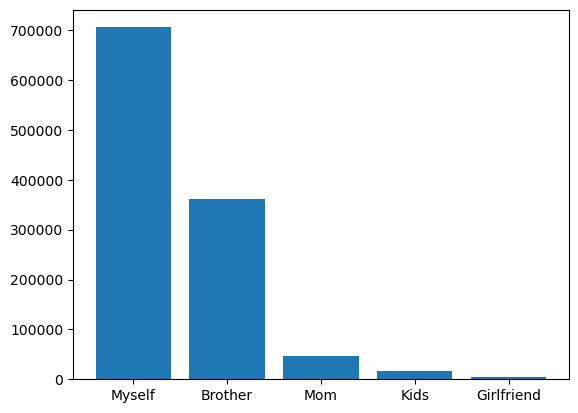

In [179]:
# Use *zip to iterate over the key/values in viewTime dictionary and plot
plt.bar(*zip(*viewTime.items()))

plt.show()

<p> I think a better way to visualize the data is to see the average viewing time per interaction. If a user tends to watch more in one sitting, they'll have less interactions, but a higher overall average time per each view - vice versa with someone who tends to watch less per view (i.e. a couple episode) with more total interactions. </p>

<p> Using the totals of individual profile interactions from earlier, let's divide Duration by total interactions to get an average viewing time for each user. There's a big drop in interactions after my Mom's profile, so for the sake </p>

In [180]:
display(df.loc[df['Profile Name']=='Myself','Duration'].sum()/28887)
display(df.loc[df['Profile Name']=='Brother','Duration'].sum()/14407)
display(df.loc[df['Profile Name']=='Mom','Duration'].sum()/1910)

Timedelta('0 days 00:24:52.956070204')

Timedelta('0 days 00:25:31.513083917')

Timedelta('0 days 00:24:33.519895287')

<p> What seems odd is the average viewing time per profile is less than 30 minutes each. After inspecting the dataframe, it appears there we're a lot of viewings with short Durations. Each of these contained data in the Supplemental Video Type column. Some research returned that Supplemental Video Types we're when a trailer was played, the mouse hovered over a title and played a quick teaser, some type of promotional trailer was played, etc. Each of these we're logged away, but weren't true viewing interactions. Ultimately, these we're being added to the overall total of viewing interactions and lowering the average. To get a more true average viewing time, we'll need to get a count of these, subtract from total interactions, and again plot. </p>

In [181]:
display(df.loc[df['Supplemental Video Type'].notnull()].sample(n=5))
# Get a count of these Supplemental interactions
df['Supplemental Video Type'].value_counts()

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
30026,Mom,2023-03-05 08:04:14+00:00,0 days 00:01:17,Autoplayed: user action: None;,Character Intro Clip: The Hatchet Wielding Hit...,HOOK,Roku 3 Set Top Box,00:01:17,Not latest view,US (United States)
34396,Brother,2022-10-07 03:37:27+00:00,0 days 00:00:07,Autoplayed: user action: None;,Hubie Halloween - Baseline Clip 3,HOOK,Amazon Fire TV Stick 2020 Lite Streaming Stick,00:00:07,00:00:07,US (United States)
29880,Mom,2023-04-23 06:01:39+00:00,0 days 00:00:08,Autoplayed: user action: None;,Dare Me: Season 1_hook_primary_16x9,HOOK,Roku 3 Set Top Box,00:00:08,00:00:08,US (United States)
32753,Brother,2023-02-19 16:39:18+00:00,0 days 00:01:57,Autoplayed: user action: None;,Season 1 Trailer: My Dad the Bounty Hunter,TRAILER,Roku Nemo Set Top Box,00:01:57,Not latest view,US (United States)
2182,Myself,2021-12-05 08:10:55+00:00,0 days 00:00:08,Autoplayed: user action: None;,Trailer: Untold: Crime & Penalties,TRAILER,Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV,00:00:08,00:00:08,US (United States)


HOOK              2911
TRAILER           1410
TEASER_TRAILER     266
RECAP               14
PREVIEW              6
PROMOTIONAL          5
BUMPER               2
Name: Supplemental Video Type, dtype: int64

<p> To get a count of viewings, not including Supplemental, we'll need to filter out null values. </p>

In [182]:
# Use isnull() to filter out null values
df['Profile Name'].loc[df['Supplemental Video Type'].isnull()].value_counts()


Myself        27219
Brother       12377
Mom            1276
Kids            469
Girlfriend      148
Name: Profile Name, dtype: int64

In [183]:
display(df.loc[df['Profile Name']=='Myself','Duration'].sum()/27219)
display(df.loc[df['Profile Name']=='Brother','Duration'].sum()/12377)
display(df.loc[df['Profile Name']=='Mom','Duration'].sum()/1276)

Timedelta('0 days 00:26:24.445497630')

Timedelta('0 days 00:29:42.702512725')

Timedelta('0 days 00:36:45.660658307')

<p> Device Type contains the type of device that was used for each viewing. Let's see which device has been most used by getting a count for each and plot the data </p>

In [184]:
df['Device Type'].value_counts()

Amazon Fire TV Stick 2020 Lite Streaming Stick    6380
FireTV Stick 2014                                 6152
Microsoft Xbox 360                                5906
PC                                                3566
Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV       3470
Vizio MG143 Wistron MT5580 NF Smart TV            3016
Roku 3 Set Top Box                                2861
FireTV STB 2015                                   1783
Vizio MG132 eMMC MT5580 TPV Smart TV              1426
WiiU                                              1188
Microsoft Xbox One                                 966
Samsung 2018 Kant-S UHD TV Smart TV                880
Chrome PC (Cadmium)                                817
Mobile                                             601
Wii Bowser                                         575
Roku Nemo Set Top Box                              520
Netflix Windows App - Cadmium Windows Mobile       511
Netflix Chrome MAC (Cadmium) HTML 5                464
Samsung 20

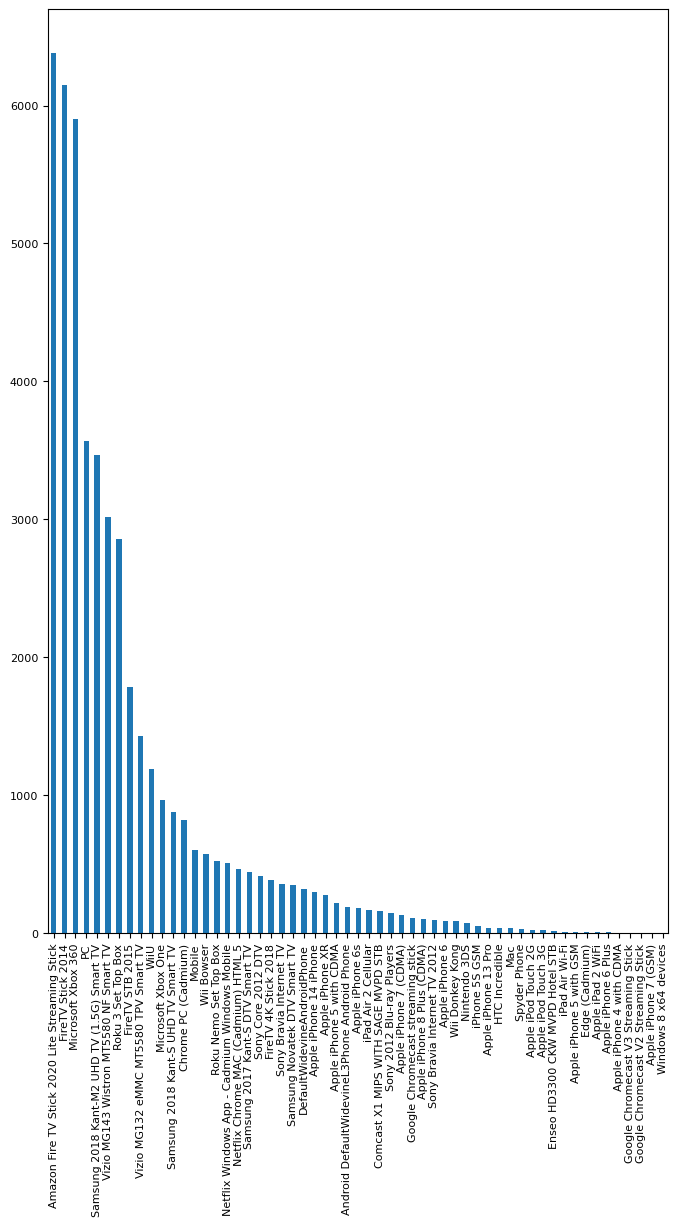

In [232]:
df['Device Type'].value_counts().plot(kind='bar',fontsize=8,figsize=(8,12))

plt.show()

<p> Across all profiles, appears an Amazon Fire Stick was the most used device  to watch Netflix, not too surprised with that one. What I'm more taken back by is that I haven't had an Xbox 360 for 6 or 7 years now and it <em>still</em> ranks as the third most watched device. </p>

In [186]:
df_myself = df.loc[df['Profile Name'] == 'Myself']

df_myself['Device Type'].value_counts()

Microsoft Xbox 360                              5859
PC                                              3462
Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV     3396
Vizio MG143 Wistron MT5580 NF Smart TV          3016
Roku 3 Set Top Box                              1552
FireTV STB 2015                                 1502
Vizio MG132 eMMC MT5580 TPV Smart TV            1425
WiiU                                            1185
Microsoft Xbox One                               947
Samsung 2018 Kant-S UHD TV Smart TV              880
Mobile                                           600
Chrome PC (Cadmium)                              557
Wii Bowser                                       538
Netflix Windows App - Cadmium Windows Mobile     473
Netflix Chrome MAC (Cadmium) HTML 5              464
Sony Core 2012 DTV                               410
Sony Bravia Internet TV                          343
Apple iPhone 5 with CDMA                         215
Apple iPhone 14 iPhone                        

<p> On my specific profile, my old Xbox 360 still has the most viewing interactions - didn't realize how much I used this device. </p>

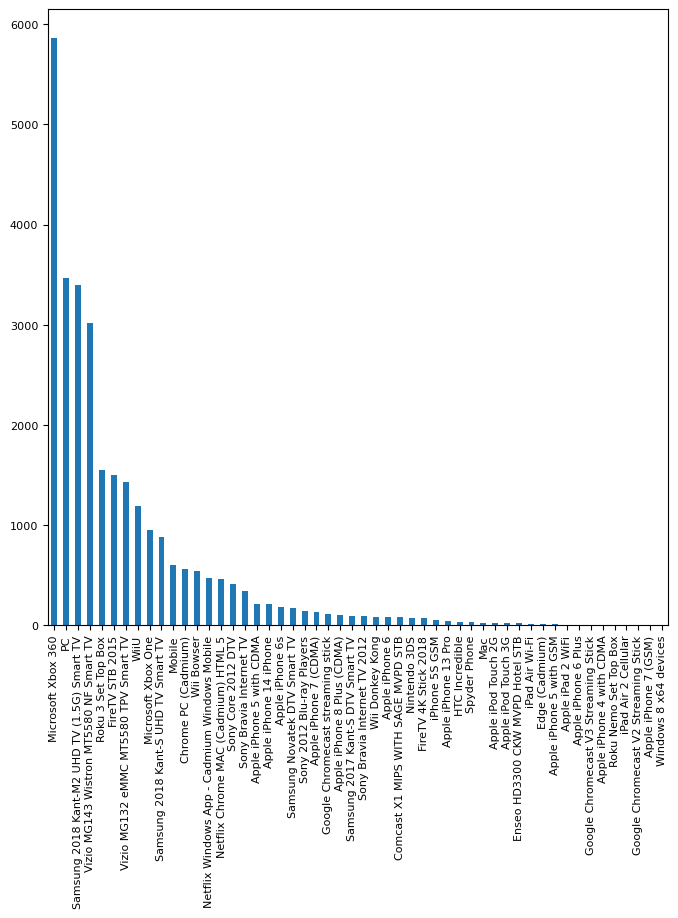

In [187]:
df_myself['Device Type'].value_counts().plot(kind='bar',fontsize=8,figsize=(8,8))

plt.show()

<p> Let's see the top 3 most viewed titles on my profile... </p>

In [239]:
df_myself['Title'].value_counts().head(3)

Malcolm in the Middle: Season 4: Boys at Ranch (Episode 8)         30
Malcolm in the Middle: Season 4: Forwards Backwards (Episode 5)    28
Malcolm in the Middle: Season 4: Stupid Girl (Episode 4)           27
Name: Title, dtype: int64

<p> This chunk of data surprised me at first as I don't think I've seen more than one episode of Malcom in the Middle. When thinking back on my friends I used to share my account with  though, things made more sense. One of them is a huge fan of this show and would replay Malcom in the Middle episodes over and over, much like people do with The Office. </p>

<p> Lastly, I'm curious to see what days and hours I tend to watch Netflix. To do this, I'll create two new columns for the day and hour, then use datetimes built-in functionalities to retrieve the day and hour from Start Time </p>

In [235]:
# Had to reset the index to not get the error 'A value is trying to be set on a copy of a slice from a DataFrame'
df_myself = df_myself.reset_index(drop = True)
# Extract days from Start Time
df_myself['Weekday'] = df_myself['Start Time'].dt.weekday
# Extract hours from Start Time
df_myself['Hour'] = df_myself['Start Time'].dt.hour

<p> Pandas by default sorts data in descending order. Not typically an issue, but our data is describing days, so it makes more sense to visualize the data in order by day of the week (Monday-Sunday). To do this, we'll use pd.Categorical to create categories from the days and sort them in numerical order. Then we'll do the same for hourly data </p>

In [198]:
df_myself['Weekday'] = pd.Categorical(df_myself['Weekday'], categories=[0,1,2,3,4,5,6], ordered=True)

df_myself_byDay = df_myself['Weekday'].value_counts()

df_myself_byDay = df_myself_byDay.sort_index()

df_myself_byDay

0    4255
1    4370
2    4153
3    4262
4    4218
5    3836
6    3793
Name: Weekday, dtype: int64

<Axes: title={'center': 'My Viewing Data By Day'}>

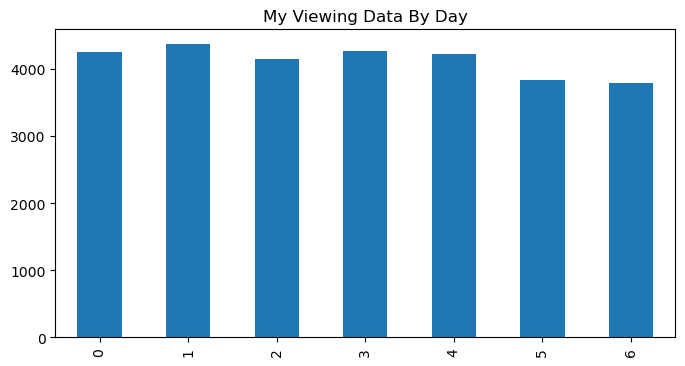

In [202]:
df_myself_byDay.plot(kind='bar', figsize=(8,4), title="My Viewing Data By Day")

<p> There's only a marginal difference, but it seems on week days I watched more Netflix. This was kind of expected, on those days I'm spending more time at home watching TV </p>

<Axes: title={'center': 'My Viewing Data By Hour'}>

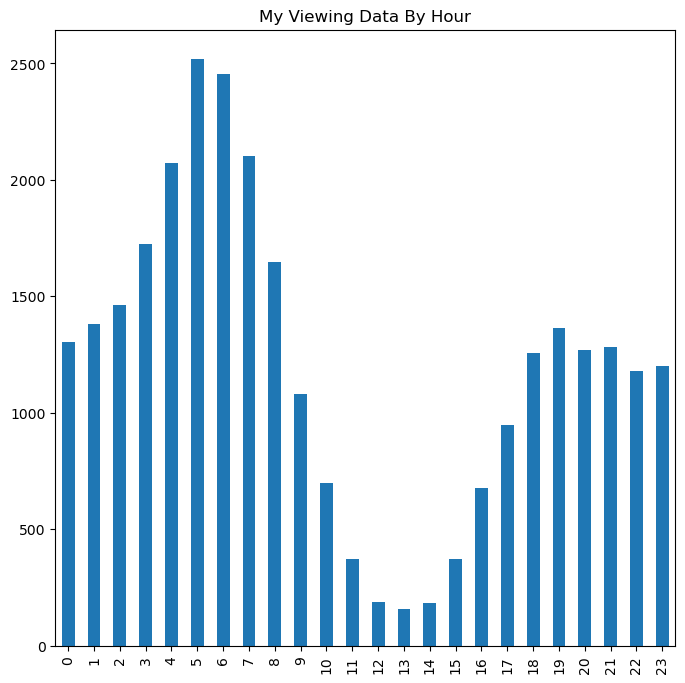

In [233]:
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

df_myself['Hour'] = pd.Categorical(df_myself['Hour'], categories=hours, ordered=True)

df_myself_byHour = df_myself['Hour'].value_counts()

df_myself_byHour = df_myself_byHour.sort_index()

df_myself_byHour.plot(kind='bar', figsize=(8,8), title="My Viewing Data By Hour")

<p> The data overall makes sense, I figured the trend would show there'd be more viewings in the morning and at night, but according to the data, the hours most watched we're 5-6AM. As previously mentioned, I used to share my account among a handful of friends and a couple of them would work night shifts, I suspect this was their viewings in the early morning hours. </p>